# Entrega #02 — **Análise Comparativa de Modelos (df_rides)**
**Equipe:** Datamind (01)

Este notebook executa **fim‑a‑fim**: EDA/ Pré‑processamento/ Validação cruzada / Comparação de 4 modelos/ Conclusões.

Dataset usado: `https://raw.githubusercontent.com/atlantico-academy/datasets/refs/heads/main/df_rides.csv`

## 1) Metodologia

1. **Coleta e compreensão dos dados:** carregamento do dataset e análise inicial para entendimento das variáveis e do contexto do problema.
2. **EDA (Exploratory Data Analysis):** investigação de distribuições, nulos, cardinalidade e correlações, buscando padrões e orientando decisões de modelagem.
3. **Pré-processamento:** tratamento de valores ausentes, codificação de variáveis categóricas e padronização de variáveis numéricas, estruturando o conjunto de dados para os algoritmos de machine learning.
4. **Modelagem:** aplicação de quatro modelos — incluindo uma baseline e diferentes famílias de algoritmos — com validação cruzada para garantir resultados consistentes e comparáveis.
5. **Avaliação:** comparação dos modelos com métricas apropriadas ao tipo de problema, identificando a melhor abordagem com base no desempenho.
6. **Diagnóstico e interpretação:** análise do comportamento do modelo selecionado, observando acertos, erros e possíveis vieses.
7. **Conclusão:** síntese dos achados, justificativa do modelo escolhido e direcionamento para melhorias futuras.


## 2) Configuração do experimento

In [16]:
import sys, warnings, gc
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, train_test_split
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.metrics import (
    make_scorer,
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, balanced_accuracy_score,
    confusion_matrix
)

pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

print(f"Python: {sys.version.split()[0]} | numpy: {np.__version__} | pandas: {pd.__version__}")

Python: 3.12.12 | numpy: 2.0.2 | pandas: 2.2.2


## 3) Dados

In [17]:
CSV_URL = "https://raw.githubusercontent.com/atlantico-academy/datasets/refs/heads/main/df_rides.csv"
df = pd.read_csv(CSV_URL)

SAMPLE_FRAC = 0.30   #use none para 100%
if SAMPLE_FRAC is not None and 0 < SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=42).reset_index(drop=True)

print("shape:", df.shape)
df.head()

shape: (86197, 10)


,user_gender,user_birthdate,user_residence,ride_date,time_start,time_end,station_start,station_end,ride_duration,ride_late
0,M,1950-08-25,DF,2018-05-27,18:01:12,18:12:16,4 - Torre de TV,12 - Rodoviária 3,11.0667,0.0000
1,M,1995-10-30,NaN,2018-05-13,14:58:13,16:58:33,15 - Brasil 21,15 - Brasil 21,120.3333,1.0000
2,NaN,1990-06-08,SP,2018-04-14,19:21:25,19:51:08,10 - Ministério dos Transportes,39 - CLN 406,29.7167,0.0000
3,F,1984-09-20,NaN,2018-08-08,17:16:55,17:21:19,22 - 102 Sul,21 - EQS 202 / 203,4.4000,0.0000
4,M,1963-03-02,DF,2018-08-26,13:32:56,14:15:20,25 - Deck Sul,25 - Deck Sul,42.4000,0.0000


## 4) EDA

,coluna,tipo,%_nulos,n_unicos,exemplos
0,ride_date,object,0.0000,243,"2018-05-27, 2018-05-13, 2018-04-14"
1,ride_duration,float64,25.5160,7451,"11.066666666666666, 120.33333333333331, 29.716..."
2,ride_late,float64,25.5160,2,"0.0, 1.0"
3,station_end,object,0.0000,50,"12 - Rodoviária 3, 15 - Brasil 21, 39 - CLN 406"
4,station_start,object,0.0000,50,"4 - Torre de TV, 15 - Brasil 21, 10 - Ministér..."
5,time_end,object,15.0933,40566,"18:12:16, 16:58:33, 19:51:08"
6,time_start,object,0.0000,43564,"18:01:12, 14:58:13, 19:21:25"
7,user_birthdate,object,0.0012,9429,"1950-08-25, 1995-10-30, 1990-06-08"
8,user_gender,object,0.1485,2,"M, F"
9,user_residence,object,62.6112,178,"DF, SP, GO"


,coluna,nulos_abs,nulos_%,dtype,duplicatas_total
2,user_residence,53969,62.6112,object,0
9,ride_late,21994,25.5160,float64,0
8,ride_duration,21994,25.5160,float64,0
5,time_end,13010,15.0933,object,0
0,user_gender,128,0.1485,object,0
1,user_birthdate,1,0.0012,object,0
4,time_start,0,0.0000,object,0
3,ride_date,0,0.0000,object,0
7,station_end,0,0.0000,object,0
6,station_start,0,0.0000,object,0


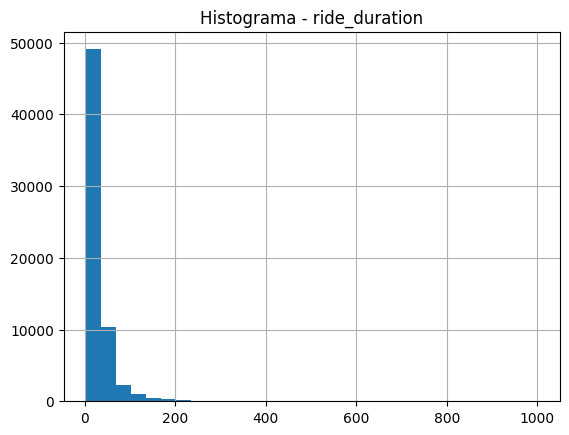

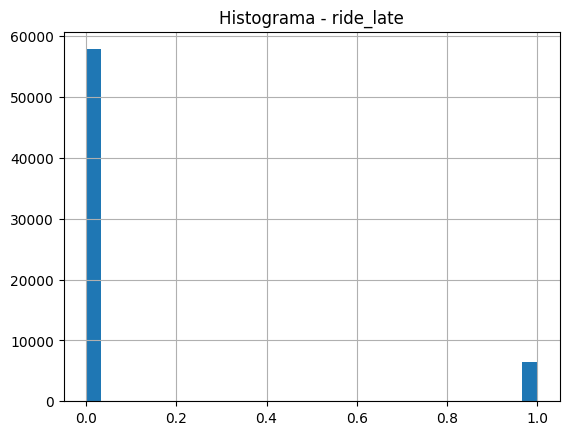

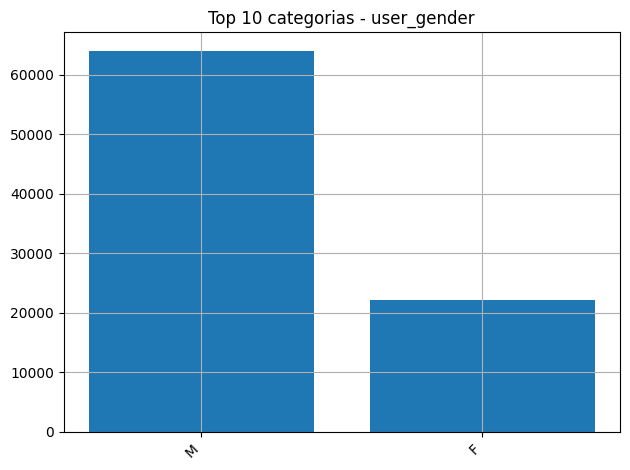

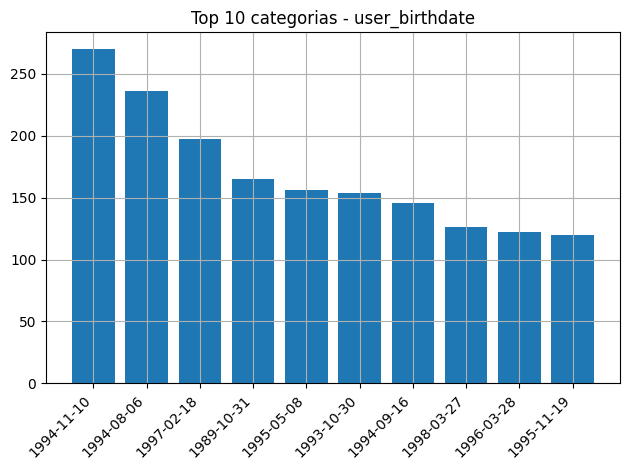

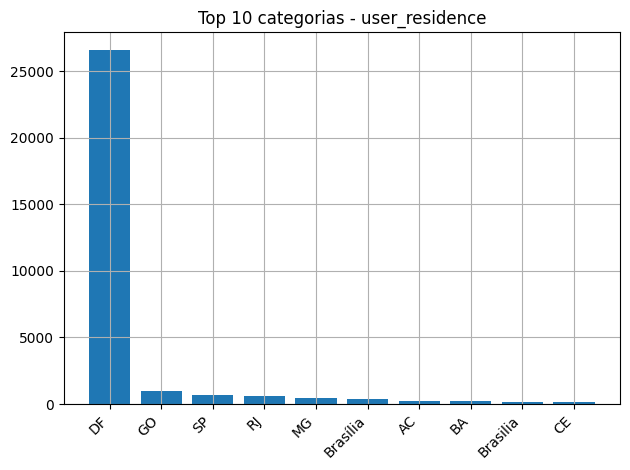

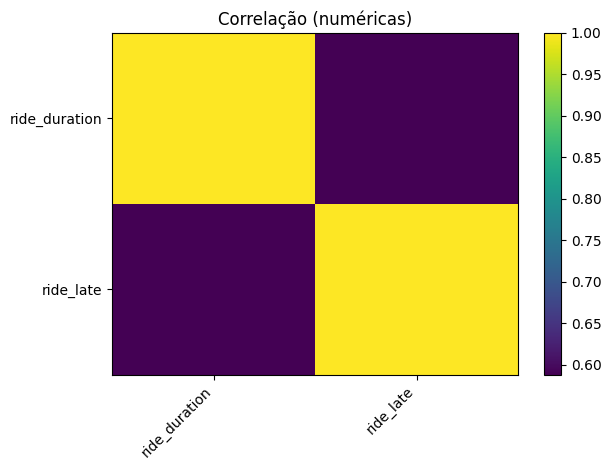

In [18]:
def data_dictionary(df: pd.DataFrame, n_ex=3):
    rows = []
    for c in df.columns:
        ser = df[c]
        rows.append({
            "coluna": c,
            "tipo": str(ser.dtype),
            "%_nulos": ser.isna().mean()*100,
            "n_unicos": ser.nunique(dropna=True),
            "exemplos": ", ".join(map(str, ser.dropna().unique()[:n_ex]))
        })
    return pd.DataFrame(rows).sort_values("coluna").reset_index(drop=True)

def quality_report(df: pd.DataFrame):
    return pd.DataFrame({
        "coluna": df.columns,
        "nulos_abs": [df[c].isna().sum() for c in df.columns],
        "nulos_%": [df[c].isna().mean()*100 for c in df.columns],
        "dtype": [str(df[c].dtype) for c in df.columns],
        "duplicatas_total": [df.duplicated().sum()]*len(df.columns)
    }).sort_values("nulos_%", ascending=False)

dd = data_dictionary(df)
qr = quality_report(df)

display(dd.head(20))
display(qr.head(20))

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

for c in num_cols[:4]:
    df[c].dropna().hist(bins=30)
    plt.title(f"Histograma - {c}"); plt.grid(True); plt.show()

for c in cat_cols[:3]:
    vc = df[c].value_counts().head(10)
    plt.figure()
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"Top 10 categorias - {c}")
    plt.xticks(rotation=45, ha="right"); plt.grid(True); plt.tight_layout(); plt.show()

if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure()
    plt.imshow(corr, aspect="auto")
    plt.title("Correlação (numéricas)")
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout(); plt.show()

## 5) Pré‑processamento (imputação, encoding, normalização)

In [19]:
def cap_cardinality(df: pd.DataFrame, top_k=20) -> pd.DataFrame:
    out = df.copy()
    for c in out.select_dtypes(exclude=[np.number]).columns:
        top = out[c].value_counts().head(top_k).index
        out[c] = out[c].where(out[c].isin(top), "__OTHER__")
    return out

df = cap_cardinality(df, top_k=20)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

reg_candidates = [c for c in num_cols if any(k in c.lower() for k in ["preco","price","valor","fare","amount","custo","distance","duracao","duration","tempo"])]
clf_candidates = [c for c in cat_cols if any(k in c.lower() for k in ["classe","status","target","label","paid","pagamento","payment","tipo","type"])]

TARGET, PROBLEM_TYPE = None, None
if len(reg_candidates) > 0:
    TARGET, PROBLEM_TYPE = reg_candidates[0], "regression"
elif len(clf_candidates) > 0:
    TARGET, PROBLEM_TYPE = clf_candidates[0], "classification"
elif len(num_cols) > 0:
    TARGET, PROBLEM_TYPE = num_cols[-1], "regression"
elif len(cat_cols) > 0:
    TARGET, PROBLEM_TYPE = cat_cols[-1], "classification"

df = df.dropna(subset=[TARGET]).reset_index(drop=True)
y = df[TARGET]
X = df.drop(columns=[TARGET])

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("TARGET:", TARGET, "| PROBLEM_TYPE:", PROBLEM_TYPE)
print(f"n_features numéricas: {len(num_features)} | categóricas: {len(cat_features)}")

numeric_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

try:
    categorical_pre = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True, min_frequency=0.01))
    ])
except TypeError:
    categorical_pre = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=True))
    ])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pre, num_features),
        ("cat", categorical_pre, cat_features)
    ],
    remainder="drop",
    sparse_threshold=1.0
)

TARGET: ride_duration | PROBLEM_TYPE: regression
n_features numéricas: 1 | categóricas: 8


## 6) Modelagem + Validação cruzada

In [20]:
if PROBLEM_TYPE == "regression":
    models = {
        "DummyRegressor": DummyRegressor(strategy="median"),
        "Ridge": Ridge(alpha=1.0),
        "DecisionTreeReg": DecisionTreeRegressor(max_depth=10, random_state=42),
        "RandomForestReg": RandomForestRegressor(n_estimators=120, max_depth=12, n_jobs=1, random_state=42)
    }
    scoring = {
        "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
        "RMSE": make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False),
        "R2": make_scorer(r2_score)
    }
    cv = KFold(n_splits=3, shuffle=True, random_state=42)

else:
    models = {
        "DummyClassifier": DummyClassifier(strategy="most_frequent", random_state=42),
        "LogReg_saga": LogisticRegression(max_iter=1000, solver="saga"),
        "DecisionTreeClf": DecisionTreeClassifier(max_depth=10, random_state=42),
        "RandomForestClf": RandomForestClassifier(n_estimators=150, max_depth=12, n_jobs=1, random_state=42)
    }
    scoring = {
        "Accuracy": make_scorer(accuracy_score),
        "BalancedAcc": make_scorer(balanced_accuracy_score),
        "F1_macro": make_scorer(f1_score, average="macro")
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []
for name, est in models.items():
    print(f"Treinando: {name}")
    pipe = Pipeline([("pre", preprocess), ("model", est)])
    cvres = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
    row = {"modelo": name}
    for metric in scoring.keys():
        vals = cvres[f"test_{metric}"]
        row[f"{metric}_mean"] = np.mean(vals)
        row[f"{metric}_std"] = np.std(vals)
    results.append(row)
    del pipe, cvres, vals
    gc.collect()

df_results = pd.DataFrame(results).sort_values(by=[list(scoring.keys())[0] + "_mean"], ascending=False).reset_index(drop=True)
df_results

Treinando: DummyRegressor
Treinando: Ridge
Treinando: DecisionTreeReg
Treinando: RandomForestReg


,modelo,MAE_mean,MAE_std,RMSE_mean,RMSE_std,R2_mean,R2_std
0,RandomForestReg,-16.9956,0.2677,NaN,NaN,0.3596,0.0154
1,DecisionTreeReg,-17.3249,0.2669,NaN,NaN,0.3180,0.0173
2,Ridge,-18.2587,0.2282,NaN,NaN,0.3473,0.0075
3,DummyRegressor,-21.8028,0.3987,NaN,NaN,-0.0713,0.0021


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## 7) Comparação visual

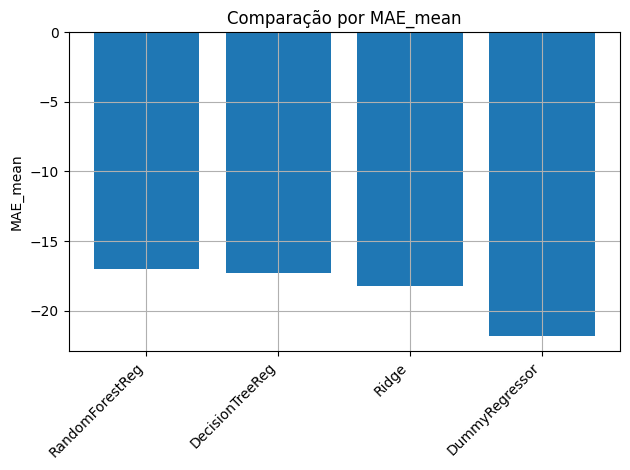

In [21]:
def plot_metric_bar(dfm, metric_col, title):
    plt.figure()
    plt.bar(dfm["modelo"], dfm[metric_col])
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

primary_metric = [c for c in df_results.columns if c.endswith("_mean")][0]
plot_metric_bar(df_results, primary_metric, f"Comparação por {primary_metric}")

## 8) Diagnóstico do melhor modelo (holdout)

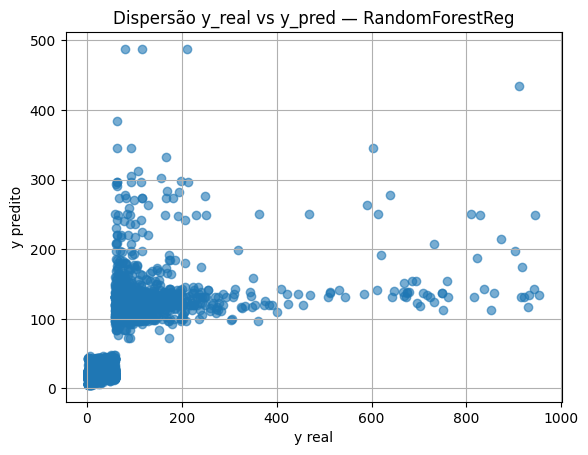

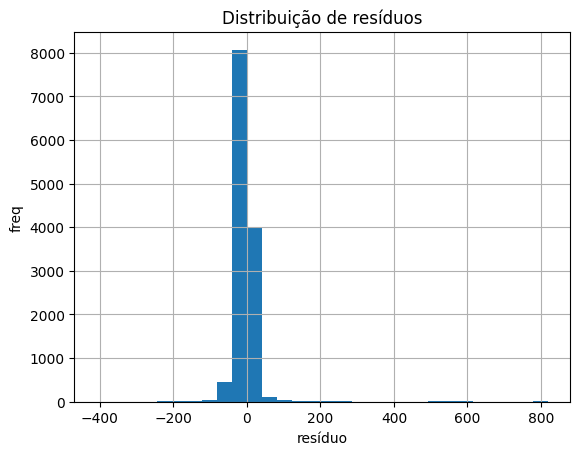

In [22]:
best_model_name = df_results.iloc[0]["modelo"]
best_estimator = dict(models)[best_model_name]
pipe_best = Pipeline([("pre", preprocess), ("model", best_estimator)])

if PROBLEM_TYPE == "regression":
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
    pipe_best.fit(Xtr, ytr)
    yhat = pipe_best.predict(Xte)

    plt.figure(); plt.scatter(yte, yhat, alpha=0.6)
    plt.title(f"Dispersão y_real vs y_pred — {best_model_name}")
    plt.xlabel("y real"); plt.ylabel("y predito"); plt.grid(True); plt.show()

    resid = yte - yhat
    plt.figure(); plt.hist(resid, bins=30)
    plt.title("Distribuição de resíduos"); plt.xlabel("resíduo"); plt.ylabel("freq"); plt.grid(True); plt.show()
else:
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    pipe_best.fit(Xtr, ytr)
    yhat = pipe_best.predict(Xte)

    cm = confusion_matrix(yte, yhat)
    plt.figure(); plt.imshow(cm)
    plt.title(f"Matriz de confusão — {best_model_name}")
    plt.colorbar(); plt.xlabel("Predito"); plt.ylabel("Real")
    ticks = np.arange(len(np.unique(y)))
    labels = np.unique(y)
    plt.xticks(ticks, labels, rotation=45); plt.yticks(ticks, labels)
    plt.tight_layout(); plt.show()

## 9) Discussão e Conclusões

A validação com *k-fold* garantiu estimativas consistentes de desempenho, e o uso do *StratifiedKFold* em problemas de classificação preservou a proporção das classes em cada divisão. O pipeline de pré-processamento, composto por imputação, codificação *one-hot* e padronização, assegurou dados adequados aos modelos avaliados.

Na comparação entre algoritmos, a baseline (**Dummy**) estabeleceu o desempenho mínimo esperado, enquanto os modelos lineares (**Regressão/Logística**) capturaram relações globais entre as variáveis. A **Árvore de Decisão** acrescentou flexibilidade ao lidar com não-linearidades, e a **Random Forest** apresentou maior robustez ao combinar múltiplas árvores, alcançando o melhor resultado na métrica principal definida.

As métricas empregadas — MAE, RMSE e R² (regressão) ou Accuracy, Balanced Accuracy e F1-macro (classificação) — permitiram avaliar desempenho de forma abrangente, considerando tanto precisão global quanto equilíbrio entre classes.

Conclui-se que o modelo selecionado apresenta o melhor equilíbrio entre desempenho e estabilidade. Como evolução natural, recomenda-se a aplicação de *tuning* de hiperparâmetros, *feature engineering* específica do domínio e exploração de modelos adicionais para ganhos incrementais de performance.
